# Imports

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset

import torchvision.transforms as transforms
from torchsummary import summary

from medmnist import OCTMNIST

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

## Assiging CUDA device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Loading the viewing the dataset sample

Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
Dataset: octmnist
Number of samples: 97477
Sample shape: torch.Size([1, 28, 28]), Label: [0]


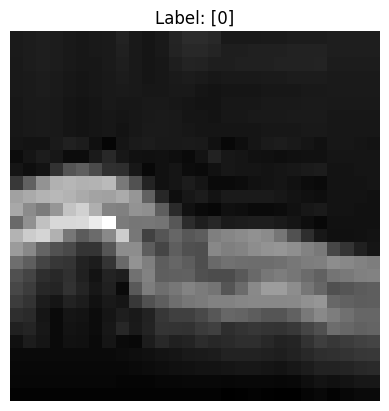

In [3]:
download = True 
batch_size = 32 
split = 'train' 

dataset = OCTMNIST(split=split, download=download, transform=transforms.ToTensor())

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset: {dataset.flag}")
print(f"Number of samples: {len(dataset)}")

sample, label = dataset[0]
print(f"Sample shape: {sample.shape}, Label: {label}")

plt.imshow(sample.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

## Creating Dataloaders

### Defining Support Functions

#### EarlyStopping

In [4]:
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

#### WeightedRandomSampling

In [5]:
def get_weighted_sampler_loader(train_dataset, batch_size):
    labels_array = np.array([train_dataset.dataset[idx][1] for idx in train_dataset.indices])

    labels_tensor = torch.tensor(labels_array, dtype=torch.long, device=device)

    class_counts = np.bincount(labels_array)
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

    sample_weights = class_weights[labels_tensor]

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    return DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

In [6]:
def get_data_loaders(batch_size=32, download=True, random_state=42, train_transform = transforms.ToTensor(), use_weighted_sampling = False):

    train_dataset = OCTMNIST(split="train", download=download, transform=train_transform)
    val_dataset = OCTMNIST(split="val", download=download, transform=transforms.ToTensor())
    test_dataset = OCTMNIST(split="test", download=download, transform=transforms.ToTensor())

    full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

    all_labels = np.concatenate([
        train_dataset.labels.flatten(), 
        val_dataset.labels.flatten(), 
        test_dataset.labels.flatten()
    ])

    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio + test_ratio, random_state=random_state)
    train_idx, temp_idx = next(splitter.split(np.zeros(len(all_labels)), all_labels))

    splitter_temp = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio / (test_ratio + val_ratio), random_state=random_state)
    val_idx, test_idx = next(splitter_temp.split(np.zeros(len(temp_idx)), all_labels[temp_idx]))

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)
    test_dataset = Subset(full_dataset, test_idx)
    
    if use_weighted_sampling:
        train_loader = get_weighted_sampler_loader(train_dataset, batch_size)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    dataset_info = {
        "Dataset": ["Train", "Validation", "Test"],
        "Number of Samples": [len(train_dataset), len(val_dataset), len(test_dataset)],
    }

    print(dataset_info)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, dataset_info

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, dataset_info = get_data_loaders(batch_size=32, download=True)

Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
{'Dataset': ['Train', 'Validation', 'Test'], 'Number of Samples': [76516, 16396, 16397]}


In [7]:
df_dataset_info = pd.DataFrame(dataset_info)
df_dataset_info

,Dataset,Number of Samples
0,Train,76516
1,Validation,16396
2,Test,16397


In [8]:
train_labels = np.array([label for _, label in train_dataset])
val_labels = np.array([label for _, label in val_dataset])
test_labels = np.array([label for _, label in test_dataset])

train_class_counts = np.bincount(train_labels.flatten())
val_class_counts = np.bincount(val_labels.flatten())
test_class_counts = np.bincount(test_labels.flatten())

print("Class Distribution in Train Set:", train_class_counts)
print("Class Distribution in Validation Set:", val_class_counts)
print("Class Distribution in Test Set:", test_class_counts)

Class Distribution in Train Set: [26218  8119  6206 35973]
Class Distribution in Validation Set: [5641 1696 1324 7735]
Class Distribution in Test Set: [5579 1680 1303 7835]


In [9]:
def get_weighted_sampler_loader(train_dataset, batch_size, device):
    labels_array = np.array([train_dataset.dataset.datasets[i][1] for i in train_dataset.indices])
    labels_tensor = torch.tensor(labels_array, dtype=torch.long, device=device)
    
    class_counts = np.bincount(labels_array)
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

    sample_weights = class_weights[labels_tensor]

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    return DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

## Visualizations

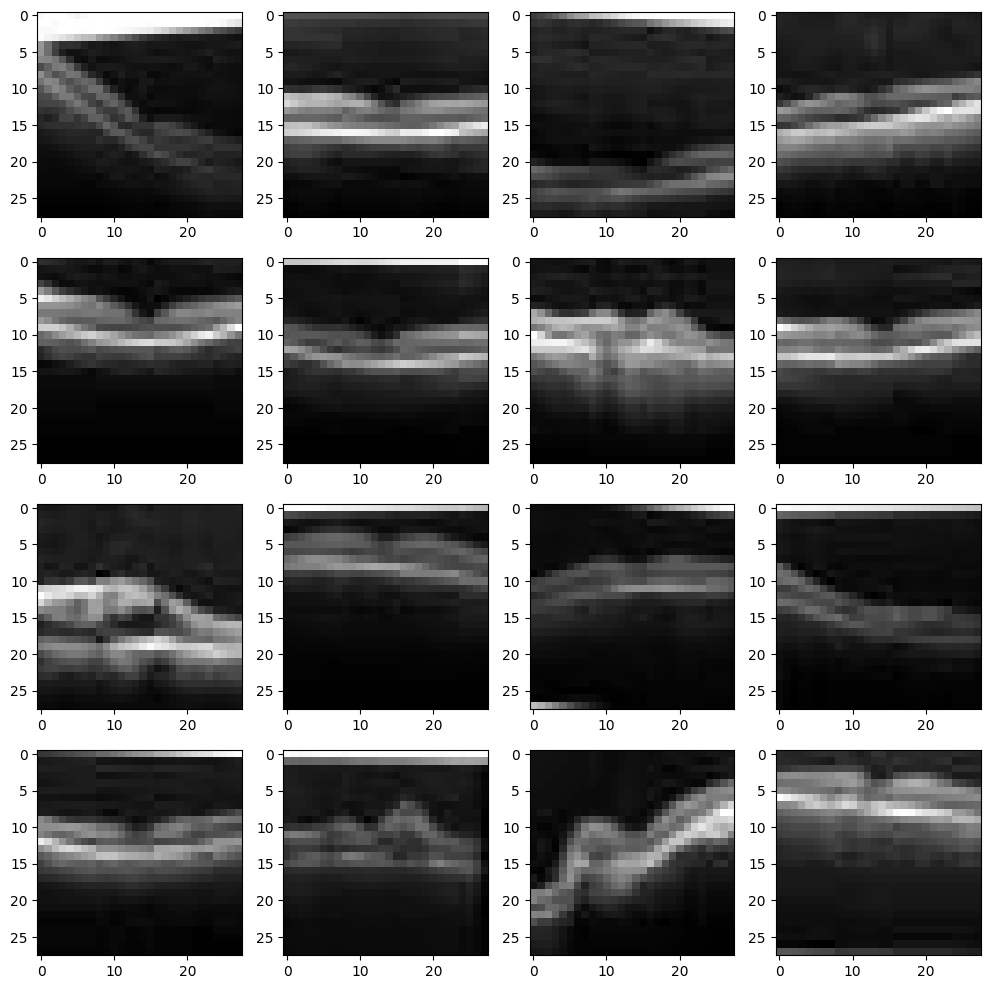

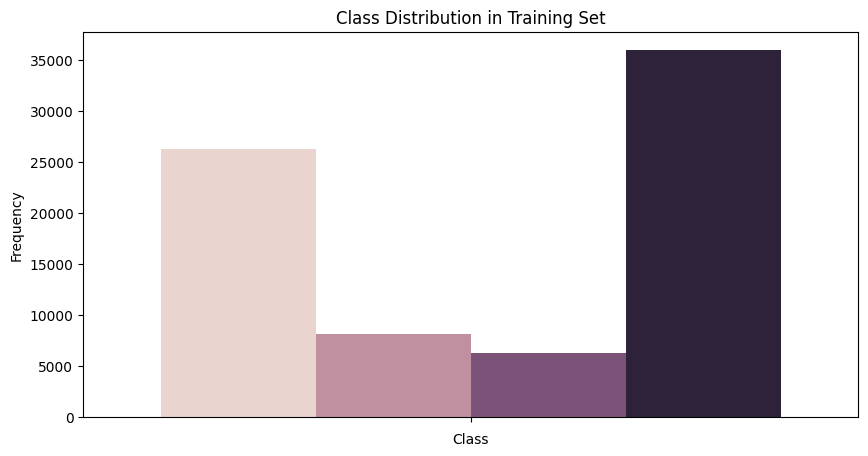

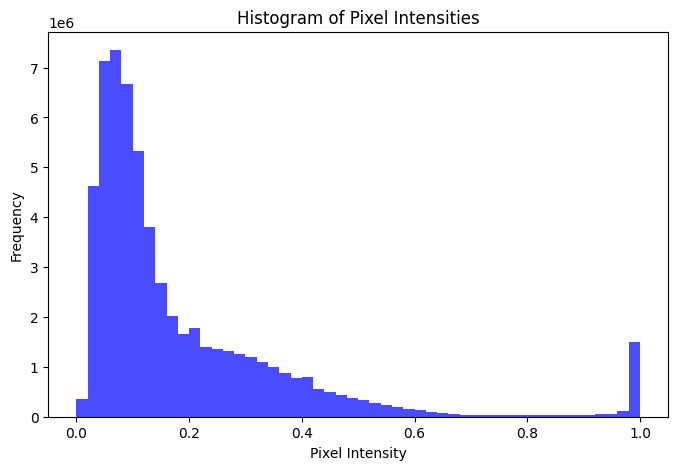

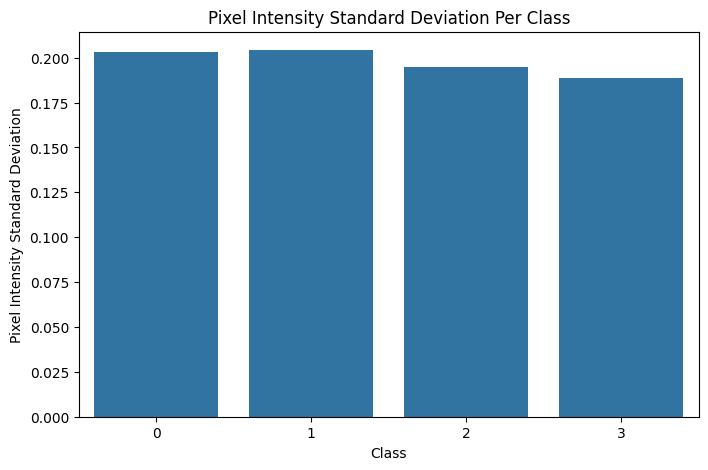

In [10]:
def display_sample_grid(dataset, num_rows=4, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    indices = np.random.choice(len(dataset), num_rows * num_cols, replace=False)
    
    temp = [ax.imshow(dataset[indices[i]][0].squeeze(), cmap="gray") or ax.set_title(f"Class: {dataset[indices[i]][1].item()}") or ax.axis("off") for i, ax in enumerate(axes.flat)]

    plt.tight_layout()
    plt.show()


def plot_class_distribution(train_class_counts, title = 'Class Distribution'):
    plt.figure(figsize=(10,5))
    sns.barplot(hue=np.arange(len(train_class_counts)), y=train_class_counts, legend = False)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution in Training Set")
    plt.show()


def plot_pixel_intensity_histogram(dataset, title="Pixel Intensity Histogram"):
    all_pixels = np.array([img.numpy().flatten() for img, _ in dataset])
    plt.figure(figsize=(8, 5))
    plt.hist(all_pixels.flatten(), bins=50, color="blue", alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

def visualize_std_per_class(dataset, labels, title="Pixel Intensity Standard Deviation Per Class"):
    unique_classes = np.unique(labels)
    
    std_values = [np.std(np.array([image.numpy().flatten() for image, label in dataset if label.item() == cls])) for cls in unique_classes]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=unique_classes, y=std_values)
    plt.xlabel("Class")
    plt.ylabel("Pixel Intensity Standard Deviation")
    plt.title(title)
    plt.show()

train_labels = np.array([label for _, label in train_dataset])

display_sample_grid(train_dataset)
plot_class_distribution(train_class_counts, "Training Set Class Distribution")
plot_pixel_intensity_histogram(train_dataset, "Histogram of Pixel Intensities")
visualize_std_per_class(train_dataset, train_labels)

## Initial Model

In [37]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = 128 * 3 * 3

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  

        x = x.view(x.size(0), -1) 

        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)  

        return x
model = CNNModel(num_classes=4).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 128]         147,584
            Linear-8                    [-1, 4]             516
Total params: 240,772
Trainable params: 240,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 0.92
Estimated Total Size (MB): 1.34
----------------------------------------------------------------


### Accounting for Weight Imbalance

In [38]:
all_labels = np.array(train_labels).ravel()
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [39]:
loss_functions = {
    "Inital_Model_CrossEntropy": nn.CrossEntropyLoss(weights = class_weights)
}

In [40]:
def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long().squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_acc, epoch_time

def evaluate_model(model, val_loader, loss_function, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long().squeeze()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    return val_loss, val_acc

def train_model_generalized(model, train_loader, val_loader, loss_functions, optimizer, scheduler, num_epochs=50, early_stopping = False):
    initial_model_state = copy.deepcopy(model.state_dict())
    train_results = {}

    for loss_name, loss_function in loss_functions.items():
        print(f"\nTraining with {loss_name} Loss on {device}...")

        model.load_state_dict(initial_model_state)
        model.to(device)

        if early_stopping:
            early_stopping = EarlyStopping(patience=2, min_delta=0.001)

        train_acc_history, val_acc_history = [], []
        train_loss_history, val_loss_history = [], []

        for epoch in range(num_epochs):
            epoch_loss, epoch_acc, epoch_time = train_one_epoch(model, train_loader, loss_function, optimizer, device)
            val_loss, val_acc = evaluate_model(model, val_loader, loss_function, device)

            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)

            if scheduler:
                scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs} - {loss_name}: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}% | Time: {epoch_time:.2f}s")

            if early_stopping:
                if early_stopping.should_stop(val_loss):
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

        torch.save(model.state_dict(), f"{loss_name}_trained_model.pth")

        train_results[loss_name] = {
            "train_acc": train_acc_history,
            "val_acc": val_acc_history,
            "train_loss": train_loss_history,
            "val_loss": val_loss_history
        }

    print("Training complete for all loss functions!")
    return train_results

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = None
train_results = train_model_generalized(model, train_loader, val_loader, loss_functions, optimizer, scheduler, num_epochs=10, early_stopping = False)


Training with Inital_Model_CrossEntropy Loss on cuda...
Epoch 1/10 - Inital_Model_CrossEntropy: 0.6964 - Acc: 74.30% | Val Loss: 0.5005 - Val Acc: 82.26% | Time: 18.35s
Epoch 2/10 - Inital_Model_CrossEntropy: 0.4862 - Acc: 82.82% | Val Loss: 0.4309 - Val Acc: 84.86% | Time: 18.69s
Epoch 3/10 - Inital_Model_CrossEntropy: 0.4239 - Acc: 85.16% | Val Loss: 0.3840 - Val Acc: 86.38% | Time: 17.99s
Epoch 4/10 - Inital_Model_CrossEntropy: 0.3810 - Acc: 86.50% | Val Loss: 0.3535 - Val Acc: 87.68% | Time: 18.21s
Epoch 5/10 - Inital_Model_CrossEntropy: 0.3475 - Acc: 87.70% | Val Loss: 0.3647 - Val Acc: 87.01% | Time: 17.53s
Epoch 6/10 - Inital_Model_CrossEntropy: 0.3202 - Acc: 88.72% | Val Loss: 0.3035 - Val Acc: 89.25% | Time: 17.54s
Epoch 7/10 - Inital_Model_CrossEntropy: 0.2985 - Acc: 89.48% | Val Loss: 0.3287 - Val Acc: 88.27% | Time: 16.97s
Epoch 8/10 - Inital_Model_CrossEntropy: 0.2781 - Acc: 90.10% | Val Loss: 0.3051 - Val Acc: 89.25% | Time: 18.05s
Epoch 9/10 - Inital_Model_CrossEntropy:

### Metrics

### Inital Model Visualizations

In [46]:
class Evaluation:
    def __init__(self, model, test_loader, loss_functions, device):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.loss_functions = loss_functions
        self.device = device
        self.results = {}

    def evaluate(self):
        for name in self.loss_functions.keys():
            print(f"\nEvaluating Model trained with {name} Loss...")

            model_path = f"{name}_trained_model.pth"
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()

            all_preds, all_labels, all_probs = [], [], []
            test_loss = 0.0

            with torch.no_grad():
                for images, labels in self.test_loader:
                    images, labels = images.to(self.device), labels.to(self.device).long().squeeze()
                    outputs = self.model(images)

                    loss = self.loss_functions[name](outputs, labels)
                    test_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    probs = torch.softmax(outputs, dim=1).cpu().numpy()
                    all_probs.extend(probs)

            test_loss /= len(self.test_loader)
            test_acc = accuracy_score(all_labels, all_preds)

            print(f"\n=== Test Results for {name} Loss ===")
            print(f"Test Accuracy: {test_acc:.4f}")
            print("Classification Report:\n", classification_report(all_labels, all_preds))

            self.results[name] = {
                "all_preds": np.array(all_preds),
                "all_labels": np.array(all_labels),
                "all_probs": np.array(all_probs),
                "test_acc": test_acc,
                "test_loss": test_loss
            }

    def plot_confusion_matrix(self):
        for name, result in self.results.items():
            cm = confusion_matrix(result["all_labels"], result["all_preds"])
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"Confusion Matrix - {name}")
            plt.show()

    def plot_accuracy_loss(self, train_results):
        plt.figure(figsize=(8, 5))
        for loss_name in self.loss_functions:
            train_acc_history = train_results[loss_name]["train_acc"]
            val_acc_history = train_results[loss_name]["val_acc"]
            plt.plot(train_acc_history, marker='o', label=f"{loss_name} Train Accuracy")
            plt.plot(val_acc_history, marker='s', label=f"{loss_name} Validation Accuracy")

        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy for Different Loss Functions")
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure(figsize=(8, 5))
        for loss_name in self.loss_functions:
            train_loss_history = train_results[loss_name]["train_loss"]
            val_loss_history = train_results[loss_name]["val_loss"]
            plt.plot(train_loss_history, marker='o', label=f"{loss_name} Train Loss")
            plt.plot(val_loss_history, marker='s', label=f"{loss_name} Validation Loss")

        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss for Different Loss Functions")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_roc_curve(self):
        plt.figure(figsize=(8, 6))

        for name, result in self.results.items():
            all_probs = result["all_probs"]
            fpr, tpr, roc_auc = {}, {}, {}

            for i in range(all_probs.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(result["all_labels"], all_probs[:, i], pos_label=i)
                roc_auc[i] = auc(fpr[i], tpr[i])

                plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} Class {i} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend()
        plt.grid()
        plt.show()

    def run_evaluation(self, train_results):
        self.evaluate()
        self.plot_confusion_matrix()
        self.plot_accuracy_loss(train_results)
        self.plot_roc_curve()
        return {name: {"test_acc": result["test_acc"], "test_loss": result["test_loss"]} for name, result in self.results.items()}


Evaluating Model trained with Inital_Model_CrossEntropy Loss...


C:\Users\ashtik\AppData\Local\Temp\ipykernel_6028\2562926779.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_locat


=== Test Results for Inital_Model_CrossEntropy Loss ===
Test Accuracy: 0.9106
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      5579
           1       0.96      0.79      0.87      1680
           2       0.75      0.41      0.53      1303
           3       0.91      0.97      0.94      7835

    accuracy                           0.91     16397
   macro avg       0.88      0.79      0.82     16397
weighted avg       0.91      0.91      0.90     16397



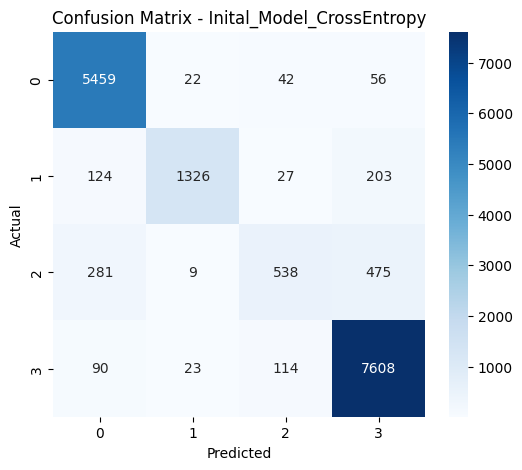

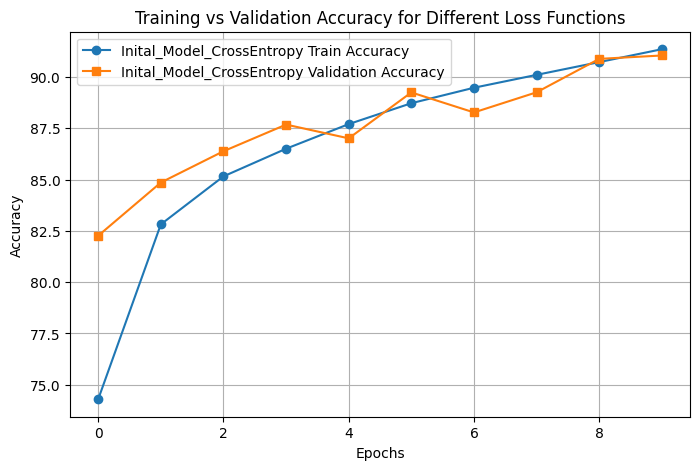

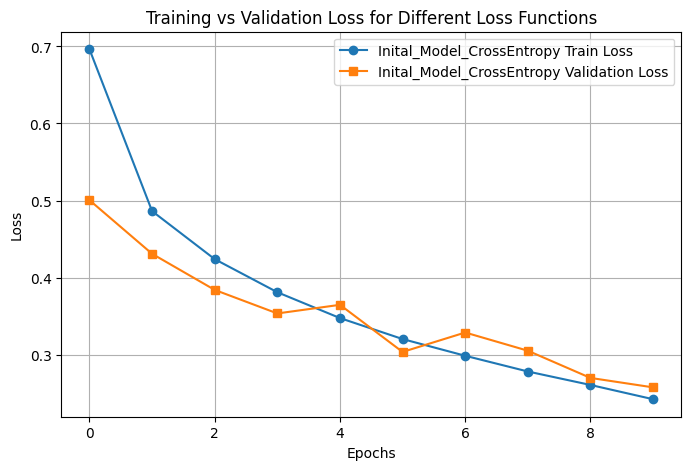

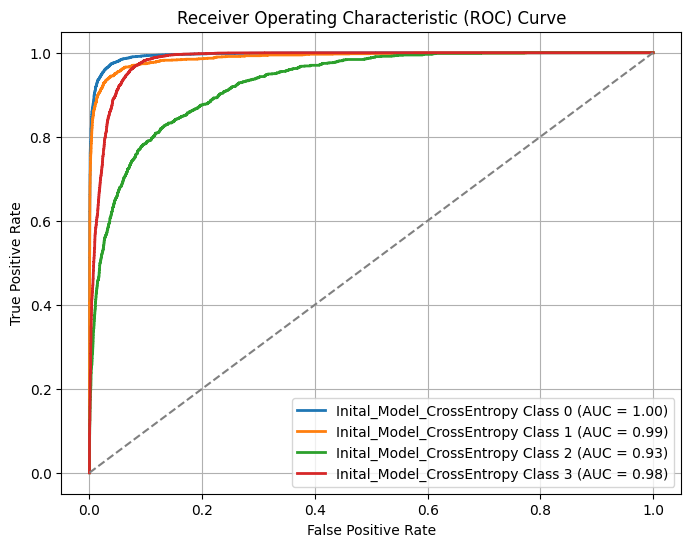

{'Inital_Model_CrossEntropy': {'test_acc': 0.9105934012319327,
  'test_loss': 0.2592746169573208}}

In [47]:
model_evaluator = Evaluation(model, test_loader, loss_functions, device)

final_eval = model_evaluator.run_evaluation(train_results)
final_eval

# Data Augmentation and Model Improvement

In [48]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),     
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.ToTensor(),
])

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader, dataset_info = get_data_loaders(batch_size=32, download=True, use_weighted_sampling = False)

Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\ashtik\.medmnist\octmnist.npz
{'Dataset': ['Train', 'Validation', 'Test'], 'Number of Samples': [76516, 16396, 16397]}


## Improved Model

In [57]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        
        self.flattened_size = 128 * 3 * 3

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(x) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=4).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
       BatchNorm2d-8            [-1, 128, 7, 7]             256
         MaxPool2d-9            [-1, 128, 3, 3]               0
          Dropout-10                 [-1, 1152]               0
           Linear-11                  [-1, 256]         295,168
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 4]           1,028
Total params: 389,316
Trainable params:

### Trying Different Loss Functions

In [53]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma 
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_weighted = self.alpha[targets]
            focal_loss *= alpha_weighted

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


loss_functions = {
    "FocalLoss": FocalLoss(alpha = class_weights),
    "CrossEntropyLabelSmoothing": nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1),
    "CrossEntropy": nn.CrossEntropyLoss()
}



In [54]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=50)
train_results = train_model_generalized(model, train_loader, val_loader, loss_functions, optimizer, scheduler, num_epochs=50, early_stopping = True)


Training with FocalLoss Loss on cuda...


C:\Users\ashtik\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50 - FocalLoss: 0.1360 - Acc: 87.27% | Val Loss: 0.1096 - Val Acc: 88.97% | Time: 20.11s
Epoch 2/50 - FocalLoss: 0.1284 - Acc: 87.51% | Val Loss: 0.1125 - Val Acc: 87.85% | Time: 20.63s
Epoch 3/50 - FocalLoss: 0.1257 - Acc: 87.62% | Val Loss: 0.1052 - Val Acc: 90.42% | Time: 20.17s
Epoch 4/50 - FocalLoss: 0.1249 - Acc: 87.64% | Val Loss: 0.1044 - Val Acc: 89.96% | Time: 20.71s
Epoch 5/50 - FocalLoss: 0.1213 - Acc: 87.84% | Val Loss: 0.1033 - Val Acc: 89.67% | Time: 20.69s
Epoch 6/50 - FocalLoss: 0.1195 - Acc: 87.99% | Val Loss: 0.1006 - Val Acc: 90.38% | Time: 22.25s
Epoch 7/50 - FocalLoss: 0.1157 - Acc: 88.15% | Val Loss: 0.1004 - Val Acc: 90.20% | Time: 21.70s
Epoch 8/50 - FocalLoss: 0.1137 - Acc: 88.24% | Val Loss: 0.0959 - Val Acc: 91.69% | Time: 20.74s
Epoch 9/50 - FocalLoss: 0.1130 - Acc: 88.32% | Val Loss: 0.0956 - Val Acc: 90.72% | Time: 21.71s
Epoch 10/50 - FocalLoss: 0.1126 - Acc: 88.13% | Val Loss: 0.0944 - Val Acc: 91.06% | Time: 19.98s
Epoch 11/50 - FocalLoss: 0.10

### Comparing Loss Fuctions and Metrics


Evaluating Model trained with FocalLoss Loss...


C:\Users\ashtik\AppData\Local\Temp\ipykernel_6028\2562926779.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_locat


=== Test Results for FocalLoss Loss ===
Test Accuracy: 0.8882
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5579
           1       0.78      0.97      0.87      1680
           2       0.50      0.85      0.63      1303
           3       0.97      0.85      0.91      7835

    accuracy                           0.89     16397
   macro avg       0.81      0.90      0.84     16397
weighted avg       0.92      0.89      0.90     16397


Evaluating Model trained with CrossEntropyLabelSmoothing Loss...


C:\Users\ashtik\AppData\Local\Temp\ipykernel_6028\2562926779.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_locat


=== Test Results for CrossEntropyLabelSmoothing Loss ===
Test Accuracy: 0.9128
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      5579
           1       0.85      0.95      0.89      1680
           2       0.59      0.79      0.67      1303
           3       0.96      0.92      0.94      7835

    accuracy                           0.91     16397
   macro avg       0.84      0.89      0.86     16397
weighted avg       0.92      0.91      0.92     16397


Evaluating Model trained with CrossEntropy Loss...


C:\Users\ashtik\AppData\Local\Temp\ipykernel_6028\2562926779.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_locat


=== Test Results for CrossEntropy Loss ===
Test Accuracy: 0.9364
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5579
           1       0.95      0.92      0.93      1680
           2       0.83      0.55      0.66      1303
           3       0.93      0.98      0.95      7835

    accuracy                           0.94     16397
   macro avg       0.92      0.85      0.88     16397
weighted avg       0.93      0.94      0.93     16397



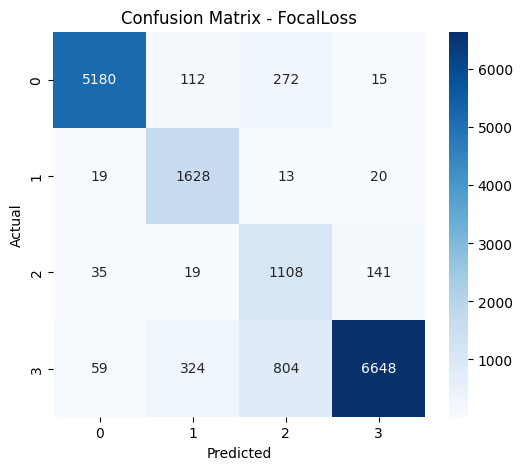

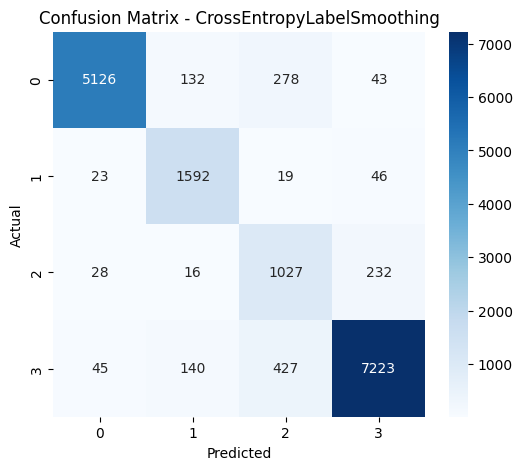

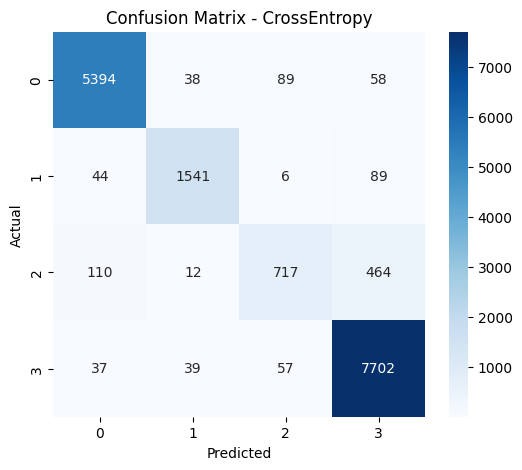

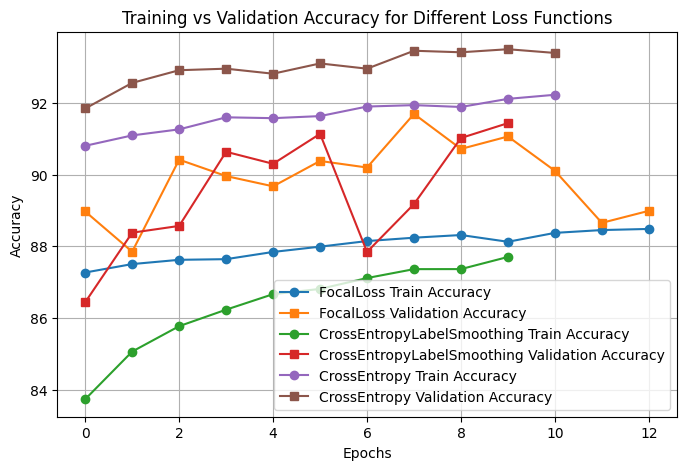

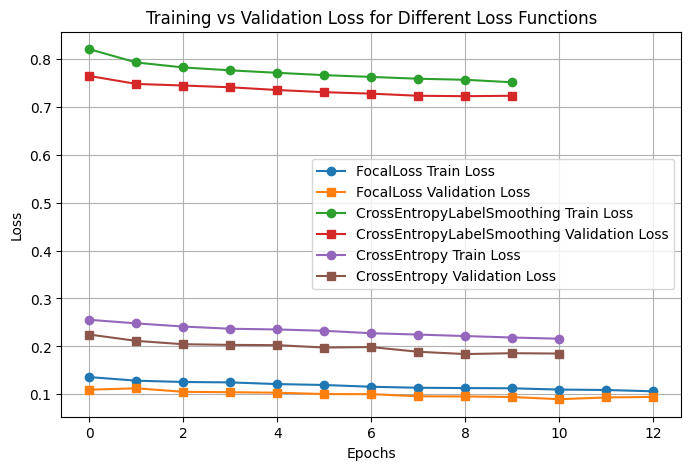

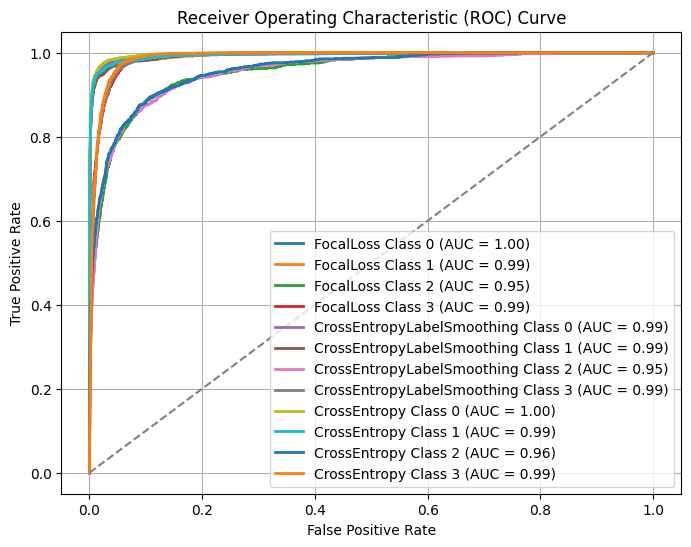

{'FocalLoss': {'test_acc': 0.88821125815698, 'test_loss': 0.10018849465451395},
 'CrossEntropyLabelSmoothing': {'test_acc': 0.9128499115691895,
  'test_loss': 0.7324094943716745},
 'CrossEntropy': {'test_acc': 0.9363908031957066,
  'test_loss': 0.18795710424284431}}

In [56]:
model_evaluator = Evaluation(model, test_loader, loss_functions, device)

test_results = model_evaluator.run_evaluation(train_results)
test_results